Gerekli kütüphaneleri eklendi.

In [46]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [47]:
# Eğitim ve test veri dizinlerinin bulunduğu yerler
train_data_dir = r'C:\\archive\\melanoma_cancer_dataset\\test'
test_data_dir = r'C:\\archive\\melanoma_cancer_dataset\\train'


In [48]:
# Veri yükleme fonksiyonu (yalnızca görüntü dosyalarını seçer)
def load_data(data_dir):
    filepaths = []
    labels = []
    for label in os.listdir(data_dir):  # Her bir sınıf için
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):  # Sadece klasörler
            for file in os.listdir(label_path):
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Sadece görseller
                    filepaths.append(os.path.join(label_path, file))
                    labels.append(label)  # Etiket olarak klasör adı
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels
})


In [49]:
# Eğitim ve test veri çerçevelerini oluştur
train_df = load_data(train_data_dir)
test_df = load_data(test_data_dir)
test_df



,filepaths,labels
0,C:\\archive\\melanoma_cancer_dataset\\train\be...,benign
1,C:\\archive\\melanoma_cancer_dataset\\train\be...,benign
2,C:\\archive\\melanoma_cancer_dataset\\train\be...,benign
3,C:\\archive\\melanoma_cancer_dataset\\train\be...,benign
4,C:\\archive\\melanoma_cancer_dataset\\train\be...,benign
...,...,...
9600,C:\\archive\\melanoma_cancer_dataset\\train\ma...,malignant
9601,C:\\archive\\melanoma_cancer_dataset\\train\ma...,malignant
9602,C:\\archive\\melanoma_cancer_dataset\\train\ma...,malignant
9603,C:\\archive\\melanoma_cancer_dataset\\train\ma...,malignant


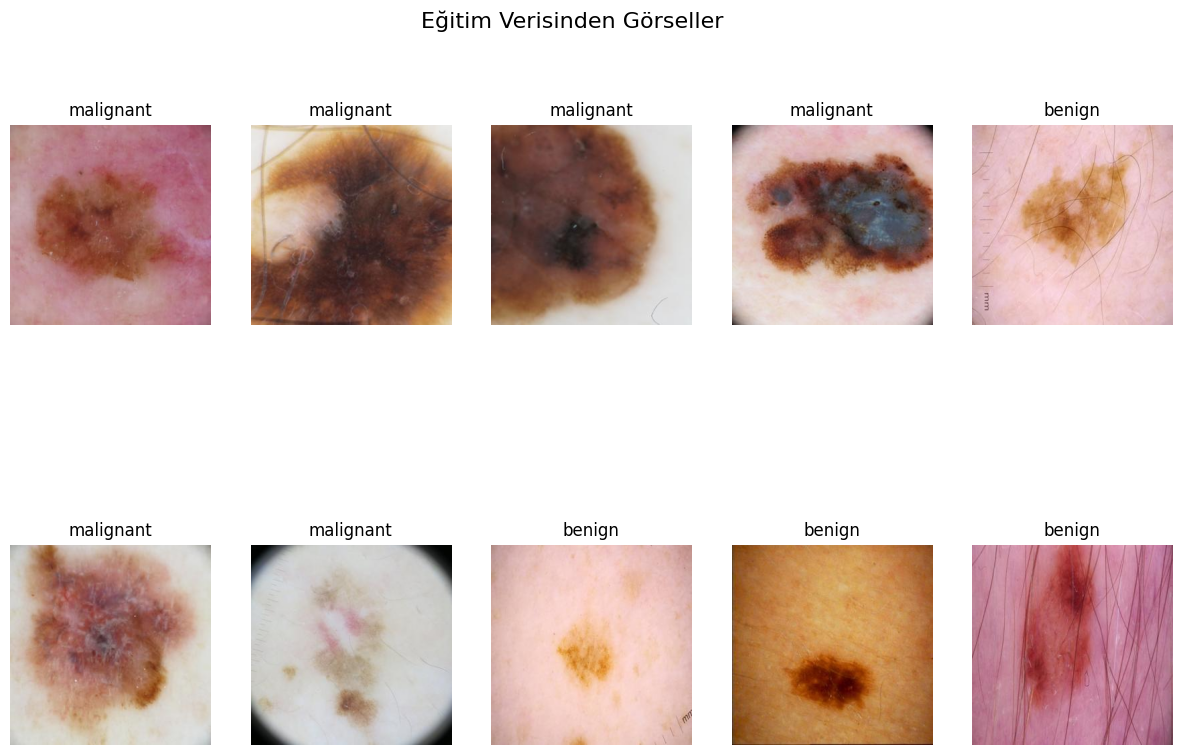

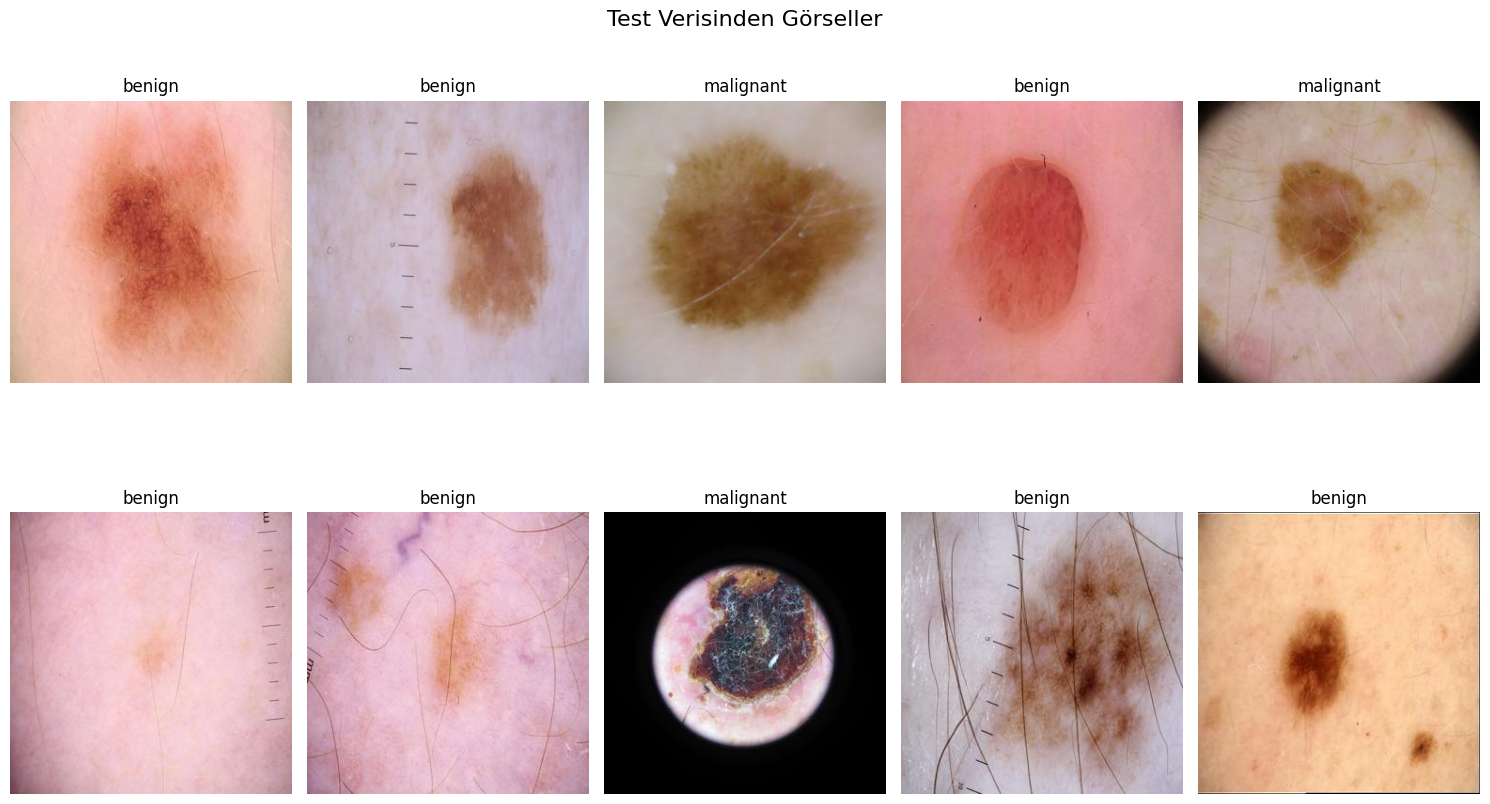

In [50]:

from PIL import Image # python imaging library görselleri yüklemek için kullanılıyor

# Görselleri ve etiketleri görselleştirme fonksiyonu
def visualize_images(dataframe, title, num_images=10):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16, y=0.92)

    # Rastgele num_images kadar veri seç
    sampled_data = dataframe.sample(num_images)

    for i, (filepath, label) in enumerate(zip(sampled_data['filepaths'], sampled_data['labels'])):
        # Görüntüyü yükle
        image = Image.open(filepath)

        # Görüntüyü göster
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

# Eğitim verisini görselleştir
visualize_images(train_df,
"Eğitim Verisinden Görseller", num_images=10)

# Test verisini görselleştir
visualize_images(test_df,
"Test Verisinden Görseller", num_images=10)

plt.tight_layout()
plt.show()

In [51]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Veri dönüştürme işlemleri

# Eğitim verisi için transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Rastgele çevirme
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Rastgele kırpma
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Test verisi için transform (sadece temel işlemler)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Özelleştirilmiş Dataset sınıfı
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.images = dataframe['filepaths'].values
        self.labels = dataframe['labels'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [52]:
# Eğitim etiketlerini kontrol et
print("Eğitim etiketleri:", train_df['labels'].unique())  # Eğitim etiketlerini yazdır

# Test etiketlerini kontrol et
print("Test etiketleri:", test_df['labels'].unique())  # Test etiketlerini yazdır


Eğitim etiketleri: ['benign' 'malignant']
Test etiketleri: ['benign' 'malignant']


In [53]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Dataset'leri oluşturma
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
test_dataset = SkinCancerDataset(test_df, transform=test_transform)

# Eğitim veri kümesini eğitim ve doğrulama olarak ayırma
train_indices, val_indices = train_test_split(
    range(len(train_df)), test_size=0.2, stratify=train_df['labels'], random_state=42
)

# Subset kullanarak eğitim ve doğrulama kümelerini oluşturma
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# DataLoader'lar ile veri yükleme
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)   # Eğitim verileri için
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)      # Doğrulama verileri için
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # Test verileri için




In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

# Cihazı belirleyin (GPU ya da CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sınıf ağırlıklarını hesaplayın (train_df'deki etiketlere göre)
class_counts = train_df['labels'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights.to(device)  # class_weights tensor'unu device'a taşıyın
# Etiketleri sayısal değerlere dönüştürme

label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['labels'])
test_df['labels'] = label_encoder.transform(test_df['labels'])

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(label_encoder.classes_)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,num_classes)  # İki sınıf: benign, malignant
)
model = model.to(device)  # Modeli device'a taşıyın

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss(weight=class_weights)  # class_weights burada kullanılıyor
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Küçük bir başlangıç learning rate'i
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Artık model ve class_weights aynı cihazda ve eğitim için hazır


In [55]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Modeli GPU'ya taşıyın (eğer varsa)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=20, smote=True, batch_size=16):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Veri dengelemesi için batched SMOTE uygulanacaksa
    if smote:
        print("Applying batched SMOTE for class balancing...")

        all_train_data = []
        all_train_labels = []

        label_encoder = LabelEncoder()

        # Eğitim verilerini topla ve etiketleri sayısal değerlere dönüştür
        for images, labels in train_loader:
            if isinstance(labels, torch.Tensor):
                labels = labels.numpy()  # Eğer etiketler tensor ise, NumPy dizisine dönüştür
            labels = label_encoder.fit_transform(labels)  # Etiketleri sayısal değerlere dönüştür
            all_train_data.append(images)
            all_train_labels.append(torch.tensor(labels, dtype=torch.long))  # NumPy yerine Tensor olarak ekle

        # Tensorleri birleştir
        all_train_data = torch.cat(all_train_data)
        all_train_labels = torch.cat(all_train_labels)

        # Check if increasing batch size helps
        batch_size = 32  # Increased batch size, if possible
        # Batched SMOTE uygulaması
        smote = SMOTE(random_state=42, k_neighbors=3)  # Reduced n_neighbors to 3

        # Batched SMOTE işlemi
        smote = SMOTE(random_state=42)
        X_res_list, y_res_list = [], []

        for i in range(0, len(all_train_data), batch_size):
            # Batched SMOTE için alt setleri oluştur
            batch_data = all_train_data[i:i + batch_size]
            batch_labels = all_train_labels[i:i + batch_size]

            # SMOTE işlemi
            batch_data_np = batch_data.view(batch_data.size(0), -1).numpy()  # 2D format
            batch_labels_np = batch_labels.numpy()

            if len(set(batch_labels_np)) > 1:  # SMOTE'nin çalışabilmesi için birden fazla sınıf gerekli
                X_res, y_res = smote.fit_resample(batch_data_np, batch_labels_np)
                X_res_list.append(torch.tensor(X_res, dtype=torch.float32))
                y_res_list.append(torch.tensor(y_res, dtype=torch.long))
            else:
                # Eğer tek bir sınıf varsa, veriyi olduğu gibi ekle
                X_res_list.append(batch_data)
                y_res_list.append(batch_labels)

        # SMOTE sonrası veriyi birleştir
        X_res_tensor = torch.cat(X_res_list)
        y_res_tensor = torch.cat(y_res_list)

        # SMOTE sonrası veriyi yeniden şekillendir (4D format: batch_size, channels, height, width)
        X_res_tensor = X_res_tensor.view(-1, 3, 224, 224)  # 3 kanal ve 224x224 boyutundaysa
        print("X_res_tensor shape before reshaping:", X_res_tensor.shape)

        # Yeni eğitim veri kümesi
        train_dataset = TensorDataset(X_res_tensor, y_res_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    # Eğitim döngüsü
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total = 0
        correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Ensure that images and labels are tensors
            images = images.to(device)

            # Etiketleri sayısal hale getirin (eğer hala string ise)
            if isinstance(labels, torch.Tensor):
                labels = labels.to(device)
            else:
                # Eğer etiketler metinse, sayısal hale getir
                labels = label_encoder.transform(labels)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

            # Optimizasyonu sıfırla
            optimizer.zero_grad()

            # İleri geçiş ve kayıp hesaplama
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Geriye doğru geçiş
            loss.backward()
            optimizer.step()

            # Kayıpları ve doğruluğu güncelle
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss /= len(train_loader)
        epoch_acc = (correct / total) * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Öğrenme oranını güncelleme
        if scheduler:
            scheduler.step()

        # Doğrulama kısmı
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)

                if isinstance(labels, torch.Tensor):
                    labels = labels.to(device)
                else:
                    labels = label_encoder.transform(labels)
                    labels = torch.tensor(labels, dtype=torch.long).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = (val_correct / val_total) * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


# Modeli eğitin
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=20, smote=True, batch_size=16
)


Applying batched SMOTE for class balancing...
X_res_tensor shape before reshaping: torch.Size([904, 3, 224, 224])


Epoch 1/20 - Training: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Epoch 1/20, Loss: 0.3993, Accuracy: 81.53%
Validation Loss: 2.6108, Validation Accuracy: 61.50%


Epoch 2/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 2/20, Loss: 0.3076, Accuracy: 86.95%
Validation Loss: 0.5190, Validation Accuracy: 85.00%


Epoch 3/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 3/20, Loss: 0.2921, Accuracy: 87.94%
Validation Loss: 0.3886, Validation Accuracy: 86.50%


Epoch 4/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 4/20, Loss: 0.3188, Accuracy: 85.84%
Validation Loss: 0.4035, Validation Accuracy: 84.50%


Epoch 5/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]


Epoch 5/20, Loss: 0.2950, Accuracy: 87.39%
Validation Loss: 0.3652, Validation Accuracy: 83.00%


Epoch 6/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]


Epoch 6/20, Loss: 0.2595, Accuracy: 89.93%
Validation Loss: 0.4086, Validation Accuracy: 85.50%


Epoch 7/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 7/20, Loss: 0.2783, Accuracy: 88.61%
Validation Loss: 0.5237, Validation Accuracy: 82.00%


Epoch 8/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]


Epoch 8/20, Loss: 0.2658, Accuracy: 88.50%
Validation Loss: 0.3697, Validation Accuracy: 87.00%


Epoch 9/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]


Epoch 9/20, Loss: 0.2194, Accuracy: 90.38%
Validation Loss: 0.3286, Validation Accuracy: 85.00%


Epoch 10/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 10/20, Loss: 0.1680, Accuracy: 94.14%
Validation Loss: 0.4902, Validation Accuracy: 88.50%


Epoch 11/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 11/20, Loss: 0.1779, Accuracy: 92.92%
Validation Loss: 0.4151, Validation Accuracy: 86.50%


Epoch 12/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch 12/20, Loss: 0.1531, Accuracy: 93.92%
Validation Loss: 0.6493, Validation Accuracy: 73.50%


Epoch 13/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 13/20, Loss: 0.1553, Accuracy: 94.14%
Validation Loss: 0.4920, Validation Accuracy: 87.50%


Epoch 14/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch 14/20, Loss: 0.1673, Accuracy: 93.92%
Validation Loss: 0.4499, Validation Accuracy: 86.00%


Epoch 15/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]


Epoch 15/20, Loss: 0.1563, Accuracy: 94.14%
Validation Loss: 0.4141, Validation Accuracy: 87.50%


Epoch 16/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch 16/20, Loss: 0.1020, Accuracy: 95.58%
Validation Loss: 0.8157, Validation Accuracy: 81.50%


Epoch 17/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 17/20, Loss: 0.1289, Accuracy: 96.35%
Validation Loss: 0.5045, Validation Accuracy: 84.50%


Epoch 18/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch 18/20, Loss: 0.2079, Accuracy: 92.37%
Validation Loss: 0.3667, Validation Accuracy: 83.50%


Epoch 19/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch 19/20, Loss: 0.1476, Accuracy: 93.81%
Validation Loss: 0.4966, Validation Accuracy: 86.00%


Epoch 20/20 - Training: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Epoch 20/20, Loss: 0.1146, Accuracy: 96.02%
Validation Loss: 0.5328, Validation Accuracy: 85.00%


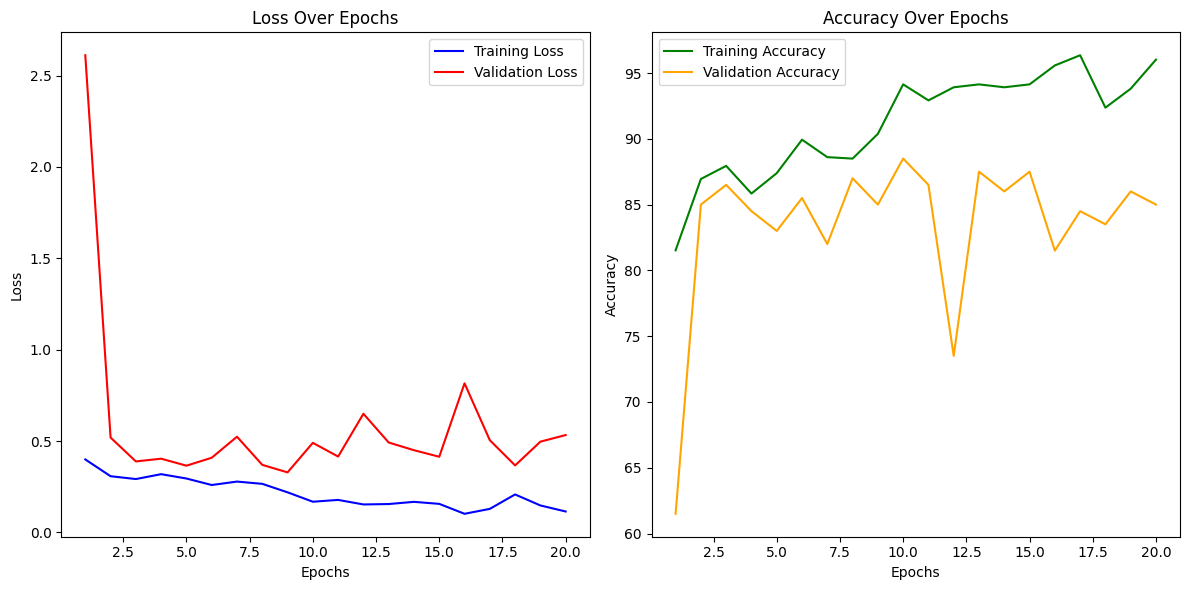

In [58]:
# Kayıp ve doğruluk grafiklerini çizme
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))

    # Kayıp (Loss) grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk (Accuracy) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Grafik çizme
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs=20)

Classification Report:
              precision    recall  f1-score   support

      benign       0.81      0.89      0.85      5000
   malignant       0.86      0.78      0.82      4605

    accuracy                           0.83      9605
   macro avg       0.84      0.83      0.83      9605
weighted avg       0.84      0.83      0.83      9605



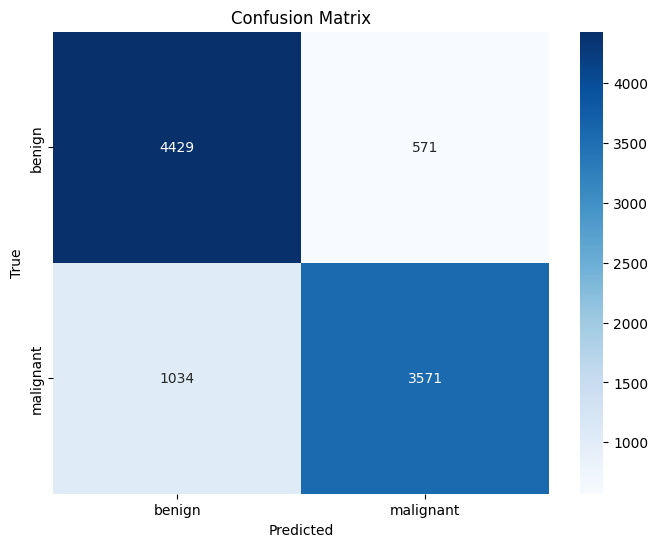

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import LabelEncoder

# Model değerlendirme fonksiyonu
def evaluate_model(model, test_loader, label_encoder, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        # Test veri kümesinde her bir örneği döngü ile işleyin
        for data in test_loader:
            # Veriyi ayıralım
            images, labels = data  # Tuple'dan veriyi ayırıyoruz

            # Etiketleri sayısal değerlere dönüştür
            labels = label_encoder.transform(labels)  # Sayısal hale getirme
            labels = torch.tensor(labels).to(device)

            # Görüntüleri cihaza taşıma
            images = images.to(device)

            # Modeli çalıştırma
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Classification report
    print("Classification Report:")
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# LabelEncoder ile etiketleri sayılara dönüştürme
label_encoder = LabelEncoder()
label_encoder.fit(['benign', 'malignant'])  # Etiketlerinizi burada tanımlayın

# Test işlemi için cihazın doğru tanımlandığından emin olun (GPU ya da CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modeli test edin
evaluate_model(model, test_loader, label_encoder, device)


In [45]:
print(train_df['labels'].unique())  # Eğitim veri setindeki etiketlerin benzersiz değerlerini kontrol et
print(test_df['labels'].unique())   # Test veri setindeki etiketlerin benzersiz değerlerini kontrol et


[0 1]
[0 1]
